In [1]:
import os
import sys
cwd = os.getcwd()
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, os.path.join(cwd, "../"))

import pickle
import torch
import importlib
import numpy as np
import pandas as pd
import copy

import src.bin.tensorify as tensorify
import src.utils.data_conversion_utils as conversion_utils
import src.data_manager.student_life_var_binned_data_manager as data_manager
import src.bin.trainer as trainer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics

from torch import nn
from src import definitions
from src.bin import validations
from src.bin import statistics
from src.bin import plotting
from src.utils.read_utils import read_pickle
from src.utils import student_utils
from src.data_manager import sub_sampler
from src.data_manager import cross_val
from src.data_manager import helper as data_manager_helper

from tabulate import tabulate 
import src.models.simple as simple_models
import src.models.gatis_mp as models

pd.set_option('max_rows', 10000)

%load_ext autoreload
%autoreload 2
feature_list = data_manager.FEATURE_LIST

##### Pickle ######
# data = read_pickle('../data/training_data/most_representative_6_hr_b_imputed_normalized_prev_stress_data.pkl')


Student ID couldn't be converted to Integer!


In [2]:
import torch.utils.data as torch_utils
from torch.utils.data import DataLoader
from tqdm import tqdm
conversion_utils.normalize

<function src.utils.data_conversion_utils.normalize(data_frame:pandas.core.frame.DataFrame, norm_type='mean', df_mean:pandas.core.series.Series=None, df_std:pandas.core.series.Series=None, df_min:pandas.core.series.Series=None, df_max:pandas.core.series.Series=None) -> pandas.core.frame.DataFrame>

In [3]:
data_path = module_path + "/data"
# file_path = data_path + "/gatis.pkl"
file_path = data_path + "/gatis-old-all.pkl"
data = pd.read_pickle(file_path)
display(data[:3])

,time,distance,displacement,distance_std,unique_tile_count,convex_hull_area,tile_change,cluster,entropy,start_term,end_term,mid_term,weekends,stress,student_id
19,2013-04-15,6.502702,6.233714,0.739355,1,285.688251,2,2,0.337921,1,0,0,0,1,42
36,2013-05-05,1.215702,0.553399,0.157909,1,14.860285,34,2,1.184381,0,0,1,1,1,22
45,2013-05-11,0.147224,0.005803,0.001179,1,0.087883,0,1,4.113632,0,1,0,1,1,3


In [40]:
learning_rate = 0.001
momentum = 0.98
n_epochs = 200
batch_size=32
np.set_printoptions(precision=3)

In [41]:
# train_loader = DataLoader([X_train.values, y_train.values] ,batch_size=32, shuffle=True)
# print(train_loader)
def pd_to_loader(X, Y, batch_size=32, shuffle=False):
    xt_train,yt_train = torch.Tensor(X), torch.LongTensor(Y)
    yt_train = yt_train.view(-1, )
    tensor_dataset_train = torch_utils.TensorDataset(xt_train, yt_train)
    loader = DataLoader(tensor_dataset_train, batch_size=batch_size, shuffle=shuffle)
    return loader
    

features_cols = ['distance', 'displacement', 'distance_std', 'unique_tile_count', 'convex_hull_area', 'tile_change', 
                 'cluster', 'entropy', 'start_term', 'end_term', 'mid_term', 'weekends']

all_cols = list(data)
all_cols.remove('stress')
all_cols.remove('student_id')
all_cols.remove('time')
features = data[all_cols + ['student_id','stress']]
# display(features[:3])

split_X = features.values.tolist()
split_y = features['student_id'].tolist()
split_y2 = features['stress'].tolist()
split_student_labels = ['{}_{}'.format(split_y[i], int(split_y2[i])) for i in range(len(split_y))]
kfolds = StratifiedKFold(n_splits=5)
loaders = []
for fold, (train_idx, test_idx) in enumerate(kfolds.split(split_X, split_student_labels)):
#     print(train_idx[:5], test_idx[:5])
    Xy_train = pd.DataFrame([features.iloc[i] for i in train_idx])
    Xy_test  = pd.DataFrame([features.iloc[i] for i in test_idx])
    
    X_train, y_train = Xy_train[features_cols], Xy_train['stress']
    X_test, y_test   = Xy_test[features_cols], Xy_test['stress']
#     print(X_train.isnull().values.any())
#     print(X_test.isnull().values.any())
    X_train, y_train = conversion_utils.normalize(X_train), pd.DataFrame(y_train).values
    X_test, y_test = conversion_utils.normalize(X_test), pd.DataFrame(y_test).values
    
    X_train = X_train.values
    X_test  = X_test.values
    print("Fold: {} train: {} test: {}".format(fold, len(train_idx), len(test_idx)))
    train_loader = pd_to_loader(X_train, y_train,batch_size=batch_size, shuffle=True)
    test_loader = pd_to_loader(X_test, y_test, batch_size=batch_size)
    loaders.append((train_loader, test_loader))
    

/Users/nsimsiri/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Fold: 0 train: 765 test: 215
Fold: 1 train: 770 test: 210
Fold: 2 train: 783 test: 197
Fold: 3 train: 796 test: 184
Fold: 4 train: 806 test: 174


In [42]:
def eval_network(loader, net, criterion, optimizer, training=False):
    running_loss = 0.0
    final_preds, final_labels = [], []
    if training:
        net.train()
    else:
        net.eval()
    for i, minibatch in enumerate(loader, 0):
        batch, labels = minibatch
        optimizer.zero_grad()
#         batch = torch.randn(batch.size())
#         print(batch)
        logits = net(batch)
        preds = torch.argmax(logits, dim=1)
        final_preds += preds.numpy().tolist()
        final_labels += labels.numpy().tolist()
        loss = criterion(logits, labels)
        if training:
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
#         print(running_loss)
    return running_loss, final_labels, final_preds

In [43]:
net = models.GatisNet()
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

GatisNet(
  (dense): Sequential(
    (0): Linear(in_features=12, out_features=57, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.35)
    (3): Linear(in_features=57, out_features=35, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25)
    (6): Linear(in_features=35, out_features=35, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15)
    (9): Linear(in_features=35, out_features=3, bias=True)
    (10): Softmax()
  )
)


/Users/nsimsiri/anaconda2/envs/python3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/nsimsiri/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


xxxxxxxxxxxxxx epoch: 0 xxxxxxxxxxxxxx
{0, 1, 2}


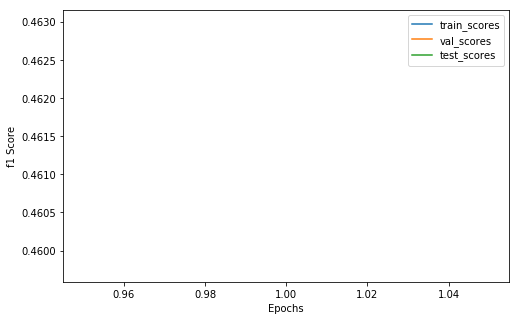

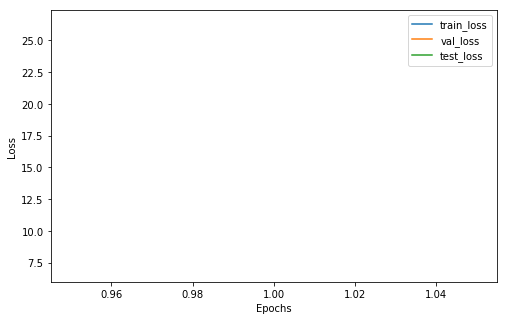

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 5 xxxxxxxxxxxxxx
{0, 1, 2}


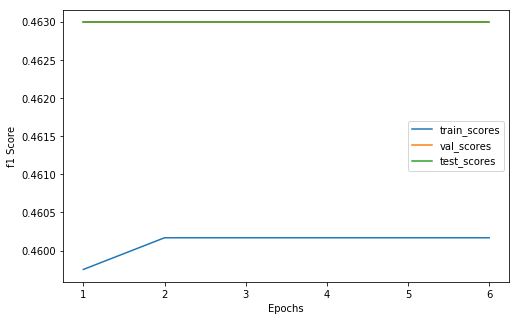

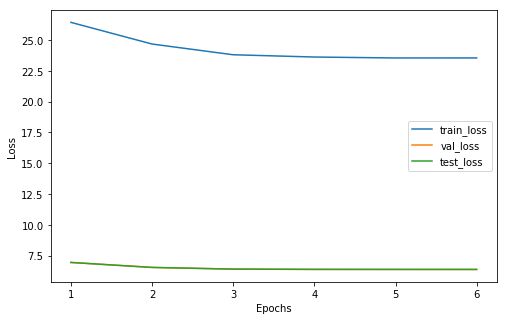

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 10 xxxxxxxxxxxxxx
{0, 1, 2}


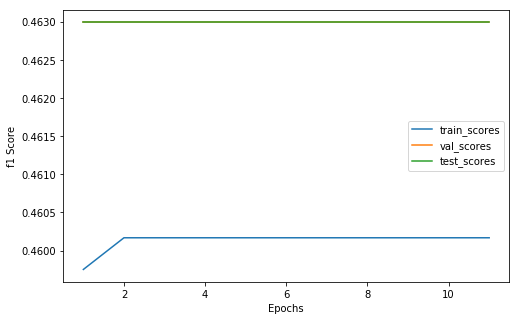

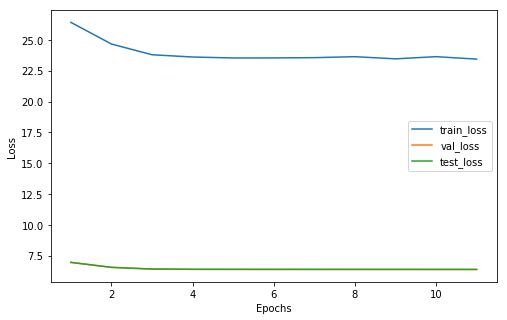

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 15 xxxxxxxxxxxxxx
{0, 1, 2}


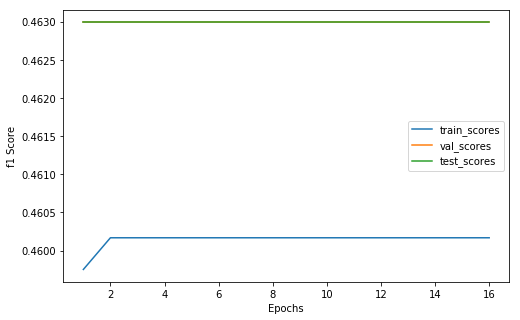

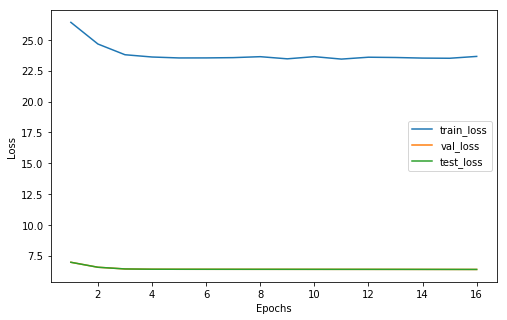

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 20 xxxxxxxxxxxxxx
{0, 1, 2}


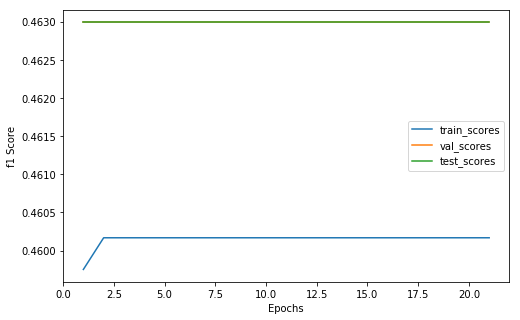

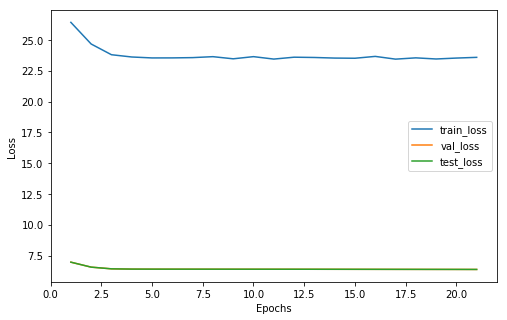

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 25 xxxxxxxxxxxxxx
{0, 1, 2}


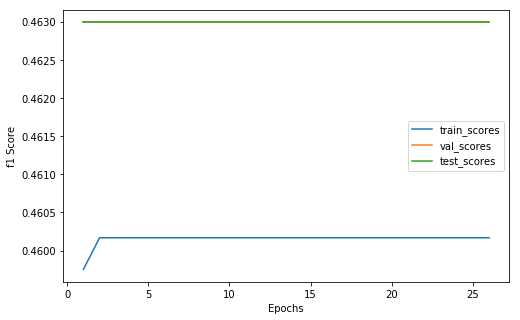

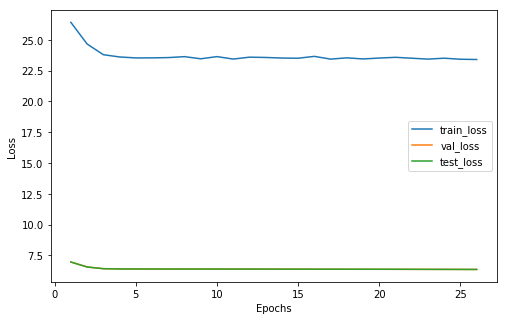

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 30 xxxxxxxxxxxxxx
{0, 1, 2}


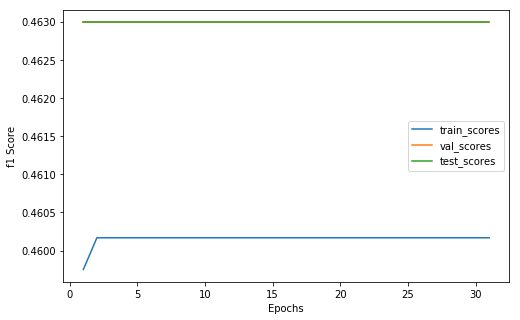

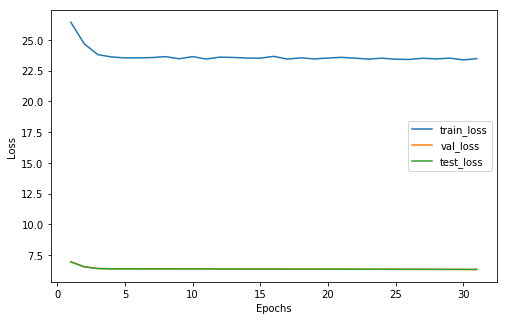

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 35 xxxxxxxxxxxxxx
{0, 1, 2}


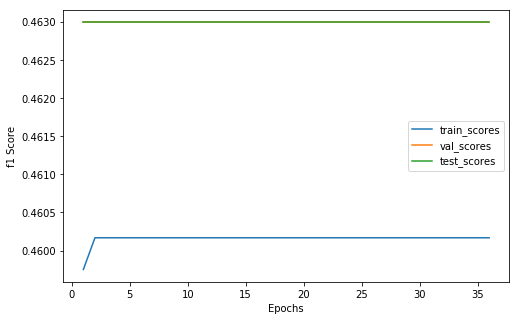

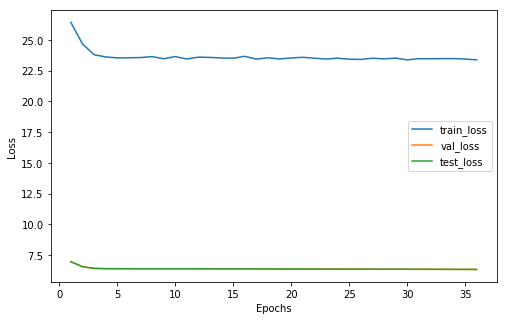

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 40 xxxxxxxxxxxxxx
{0, 1, 2}


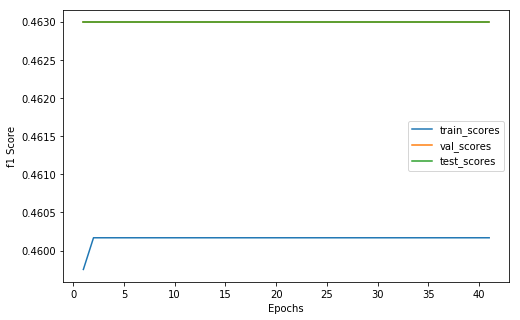

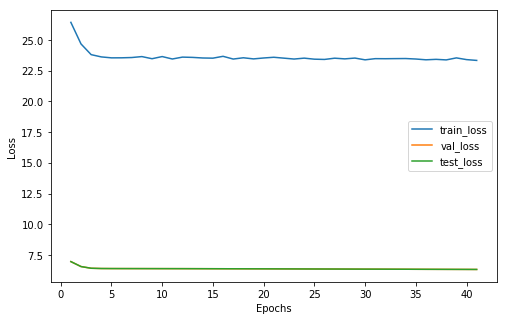

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 45 xxxxxxxxxxxxxx
{0, 1, 2}


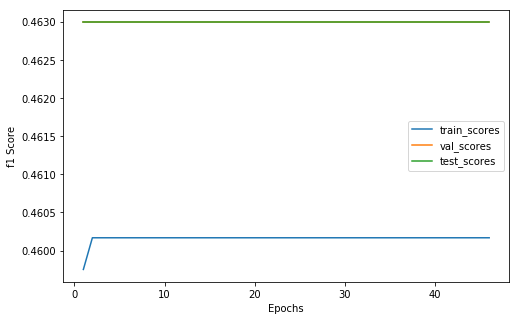

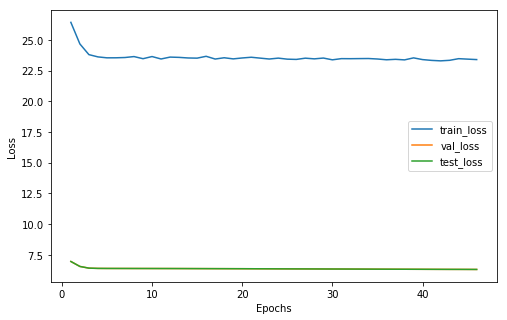

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 50 xxxxxxxxxxxxxx
{0, 1, 2}


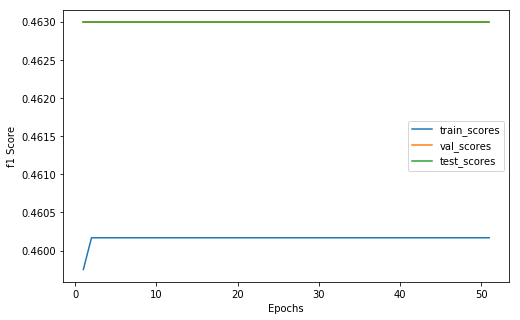

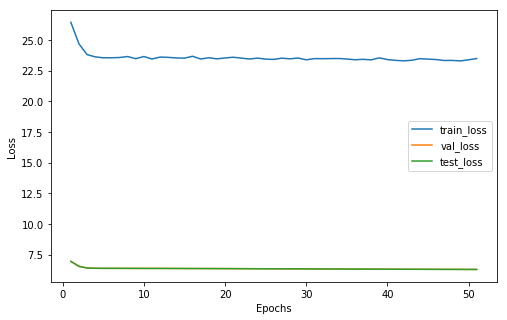

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 55 xxxxxxxxxxxxxx
{0, 1, 2}


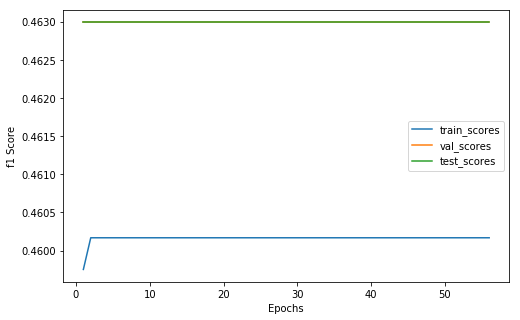

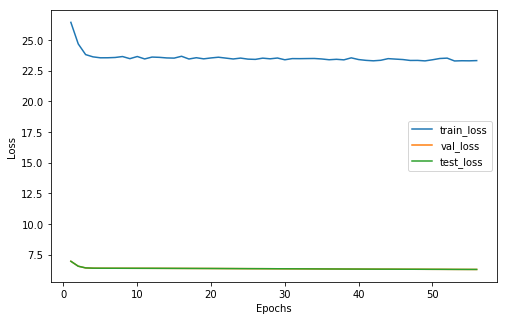

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 60 xxxxxxxxxxxxxx
{0, 1, 2}


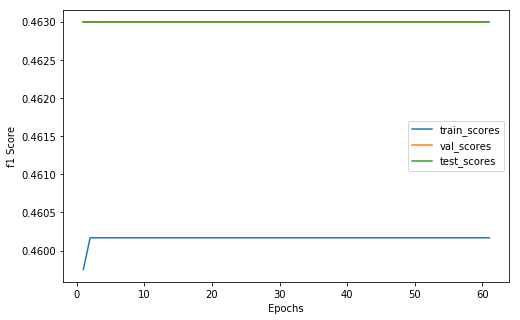

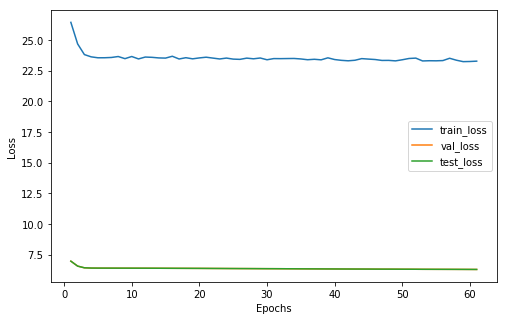

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 65 xxxxxxxxxxxxxx
{0, 1, 2}


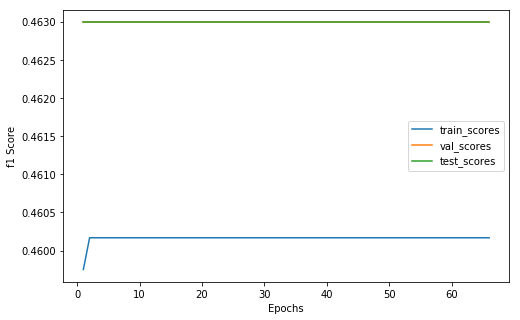

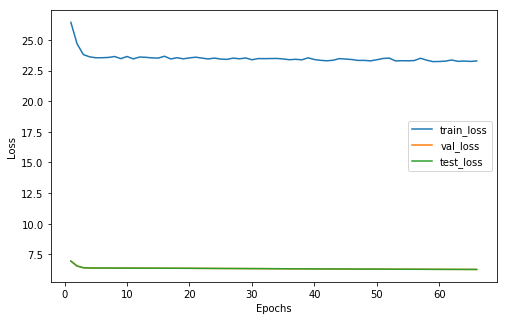

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 70 xxxxxxxxxxxxxx
{0, 1, 2}


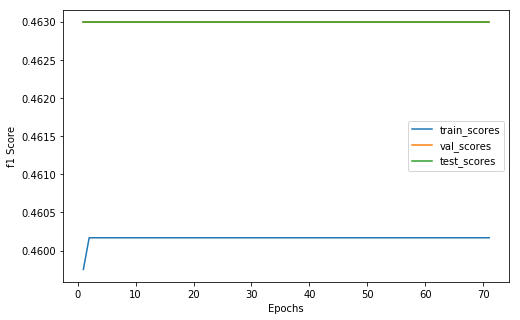

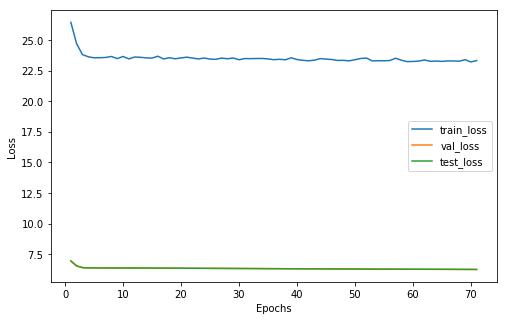

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 75 xxxxxxxxxxxxxx
{0, 1, 2}


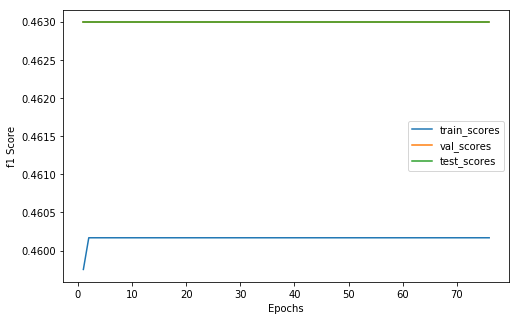

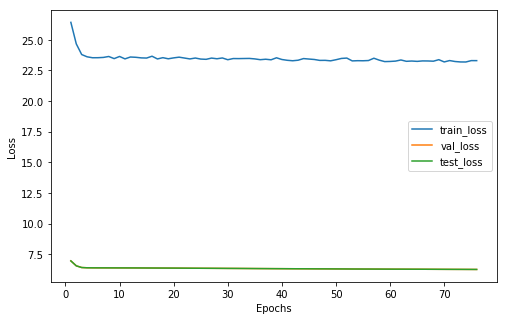

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 80 xxxxxxxxxxxxxx
{0, 1, 2}


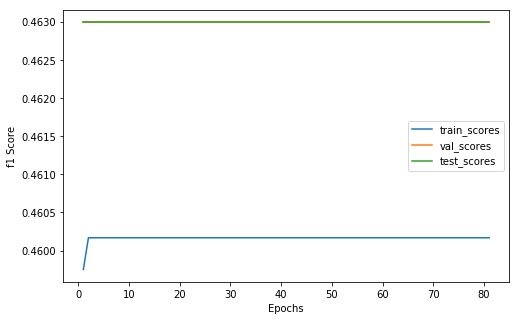

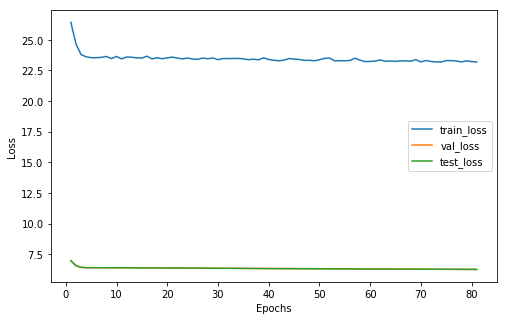

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 85 xxxxxxxxxxxxxx
{0, 1, 2}


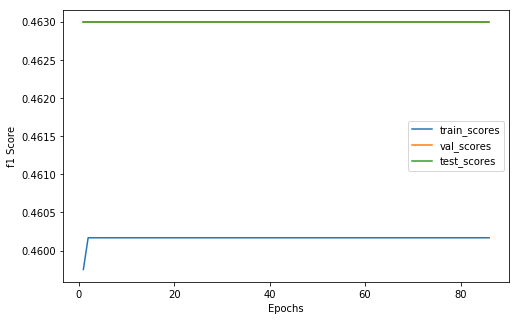

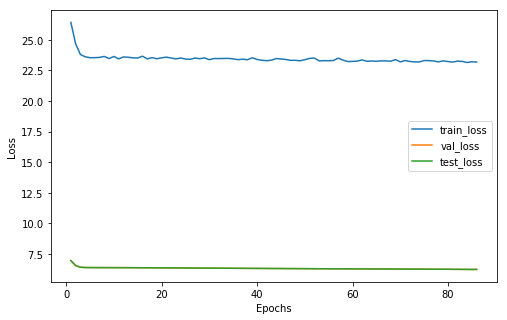

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 90 xxxxxxxxxxxxxx
{0, 1, 2}


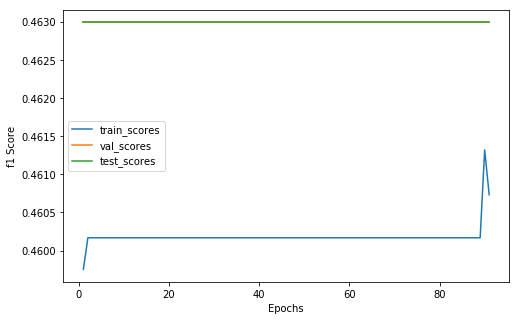

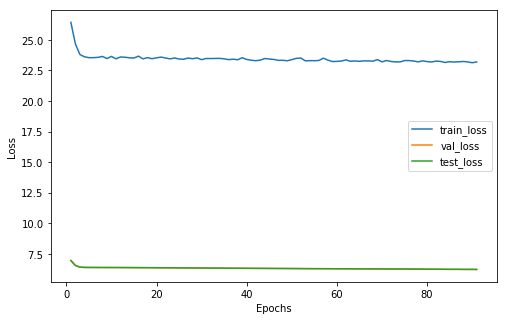

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 95 xxxxxxxxxxxxxx
{0, 1, 2}


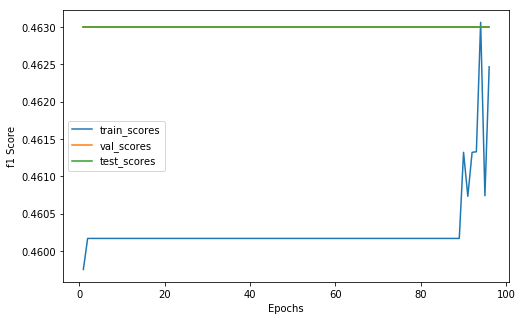

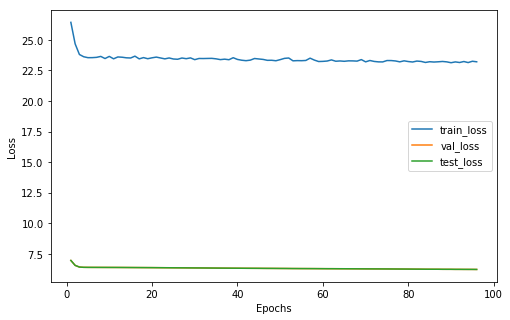

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 100 xxxxxxxxxxxxxx
{0, 1, 2}


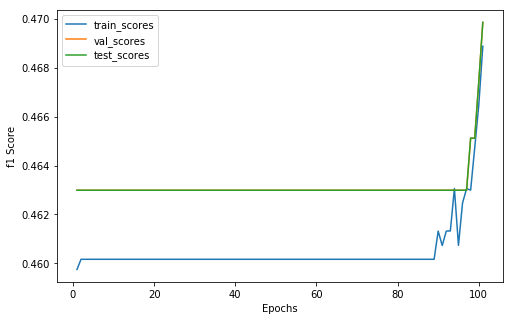

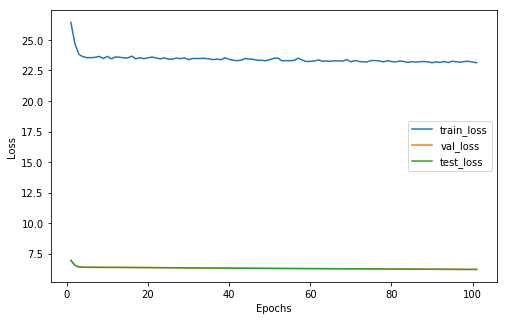

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  112  0
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 105 xxxxxxxxxxxxxx
{0, 1, 2}


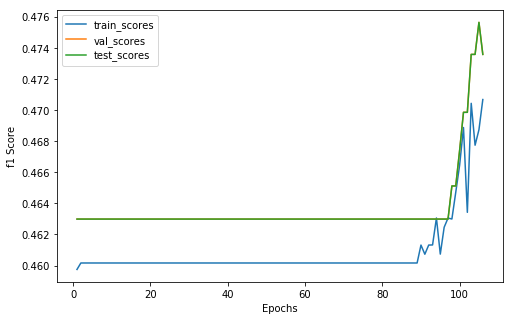

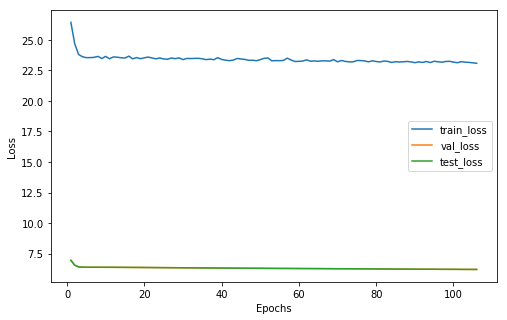

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  111  1
0   39  0
-  ---  -
xxxxxxxxxxxxxx epoch: 110 xxxxxxxxxxxxxx
{0, 1, 2}


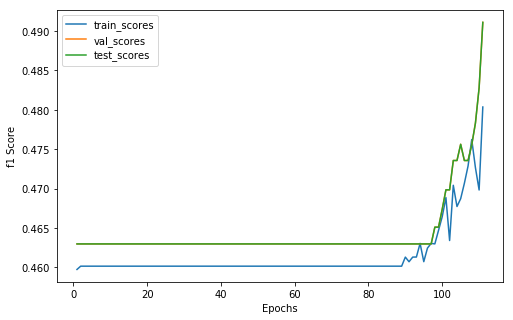

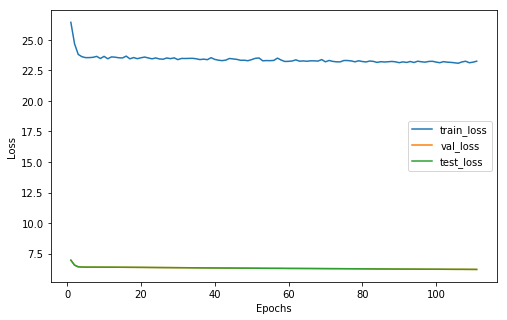

Cofusion Matrix For Test Set: 
-  ---  -
0   23  0
0  111  1
0   37  2
-  ---  -
xxxxxxxxxxxxxx epoch: 115 xxxxxxxxxxxxxx
{0, 1, 2}


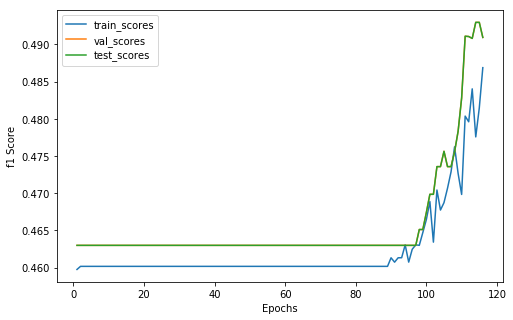

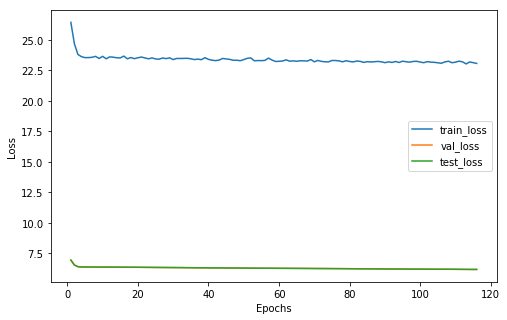

Cofusion Matrix For Test Set: 
-  ---  -
0   22  1
0  111  1
0   37  2
-  ---  -
xxxxxxxxxxxxxx epoch: 120 xxxxxxxxxxxxxx
{0, 1, 2}


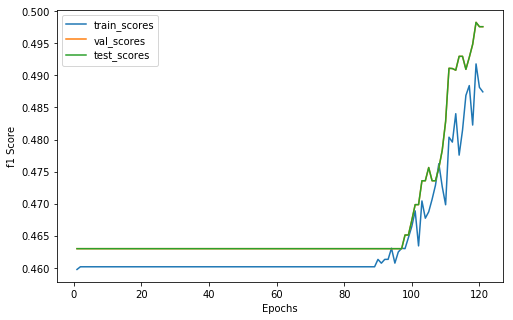

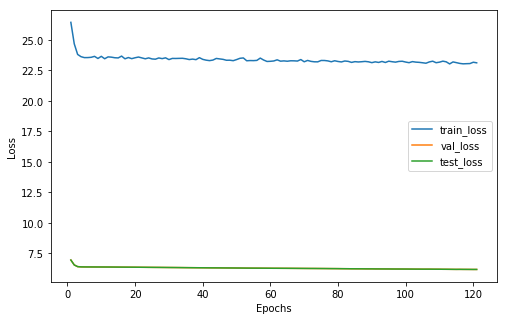

Cofusion Matrix For Test Set: 
-  ---  -
0   22  1
0  111  1
0   37  2
-  ---  -
xxxxxxxxxxxxxx epoch: 125 xxxxxxxxxxxxxx
{0, 1, 2}


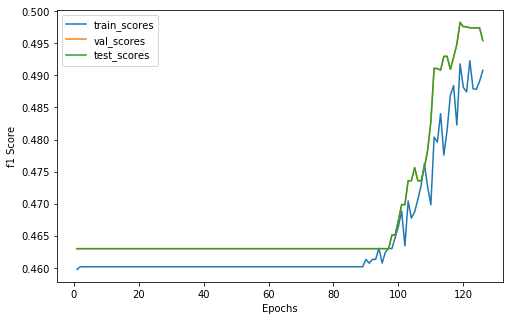

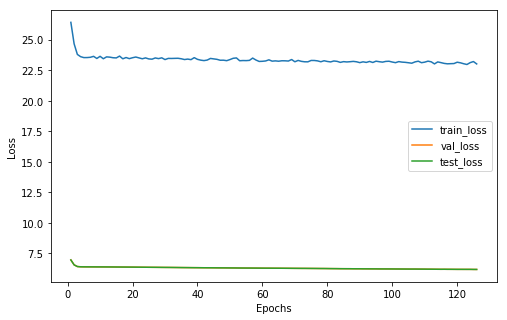

Cofusion Matrix For Test Set: 
-  ---  -
0   22  1
0  111  1
0   37  2
-  ---  -
xxxxxxxxxxxxxx epoch: 130 xxxxxxxxxxxxxx
{0, 1, 2}


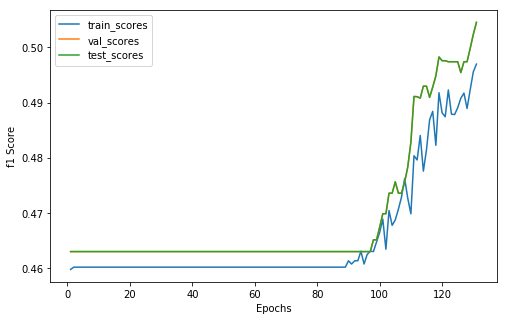

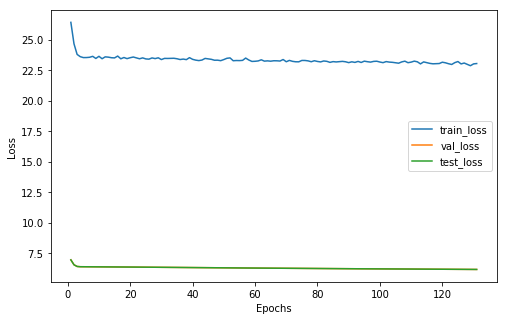

Cofusion Matrix For Test Set: 
-  ---  -
0   21  2
0  111  1
0   35  4
-  ---  -
xxxxxxxxxxxxxx epoch: 135 xxxxxxxxxxxxxx
{0, 1, 2}


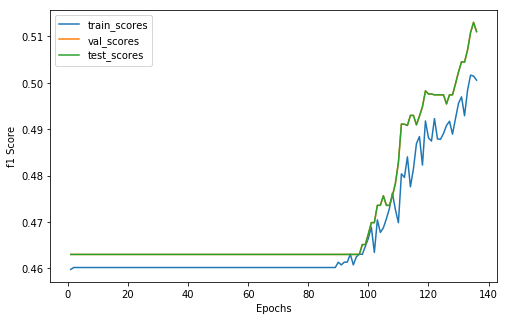

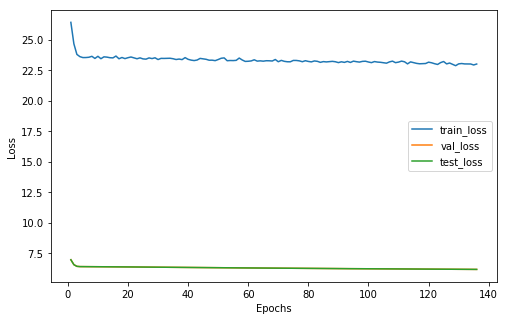

Cofusion Matrix For Test Set: 
-  ---  -
1   21  1
0  111  1
1   35  3
-  ---  -
xxxxxxxxxxxxxx epoch: 140 xxxxxxxxxxxxxx
{0, 1, 2}


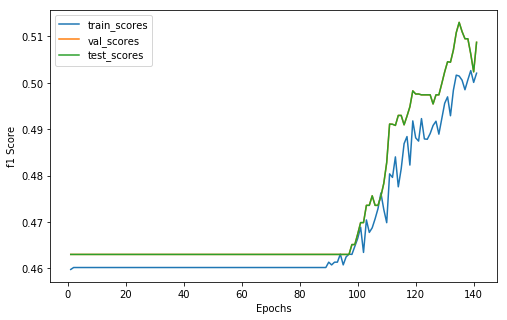

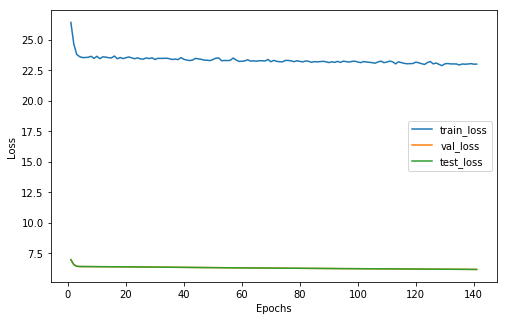

Cofusion Matrix For Test Set: 
-  ---  -
1   21  1
0  111  1
1   35  3
-  ---  -
xxxxxxxxxxxxxx epoch: 145 xxxxxxxxxxxxxx
{0, 1, 2}


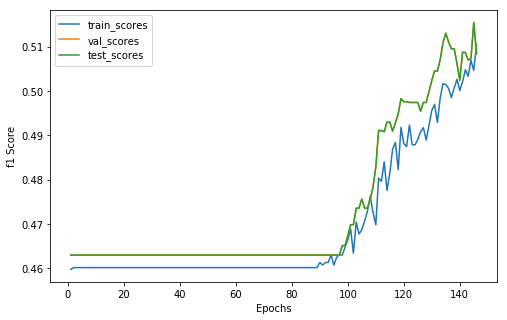

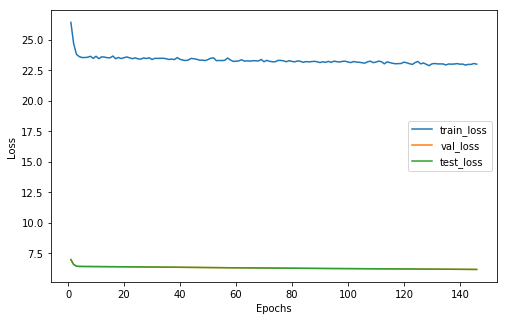

Cofusion Matrix For Test Set: 
-  ---  -
0   22  1
0  111  1
1   35  3
-  ---  -
xxxxxxxxxxxxxx epoch: 150 xxxxxxxxxxxxxx
{0, 1, 2}


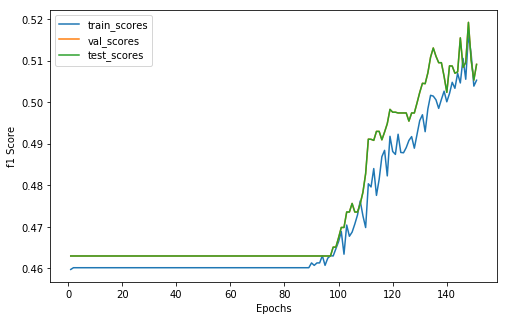

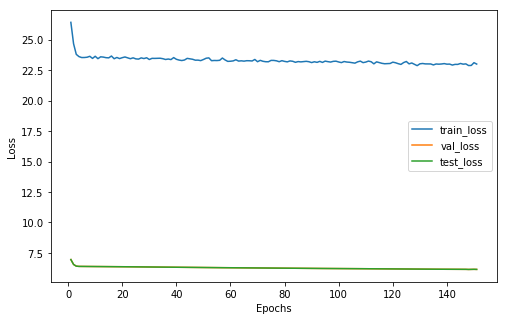

Cofusion Matrix For Test Set: 
-  ---  -
1   21  1
0  111  1
1   35  3
-  ---  -
xxxxxxxxxxxxxx epoch: 155 xxxxxxxxxxxxxx
{0, 1, 2}


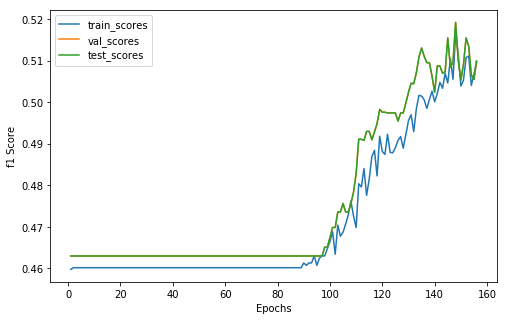

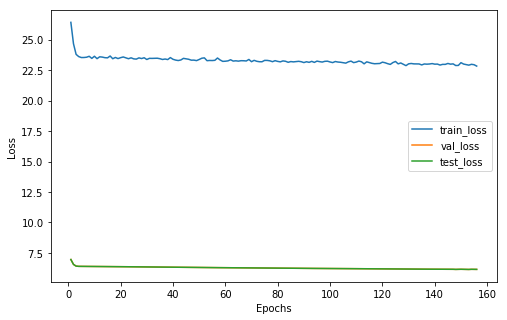

Cofusion Matrix For Test Set: 
-  ---  -
1   22  0
0  111  1
1   35  3
-  ---  -
xxxxxxxxxxxxxx epoch: 160 xxxxxxxxxxxxxx
{0, 1, 2}


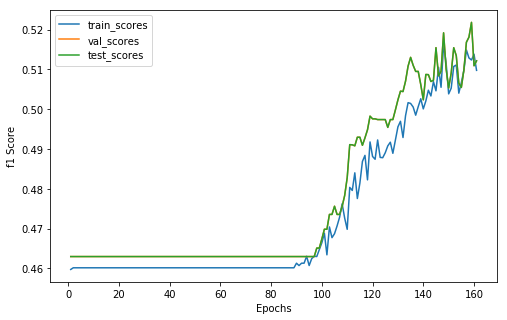

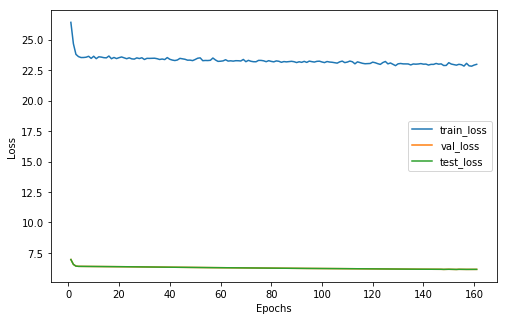

Cofusion Matrix For Test Set: 
-  ---  -
3   20  0
1  110  1
2   34  3
-  ---  -
xxxxxxxxxxxxxx epoch: 165 xxxxxxxxxxxxxx
{0, 1, 2}


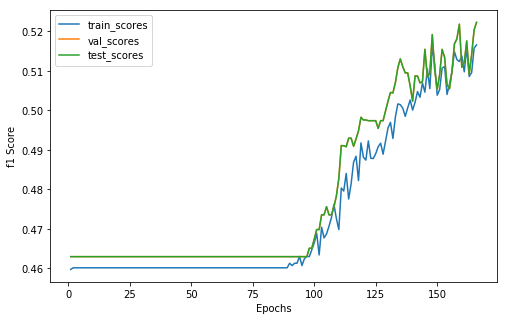

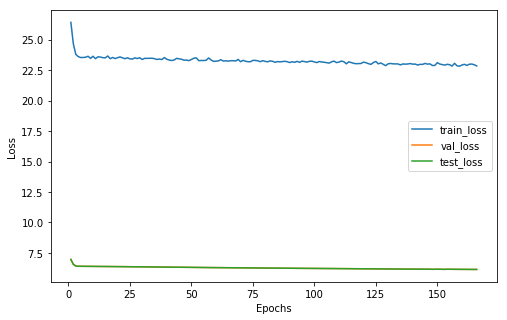

Cofusion Matrix For Test Set: 
-  ---  -
2   21  0
0  111  1
2   34  3
-  ---  -
xxxxxxxxxxxxxx epoch: 170 xxxxxxxxxxxxxx
{0, 1, 2}


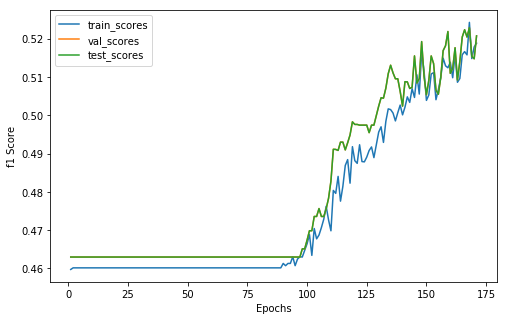

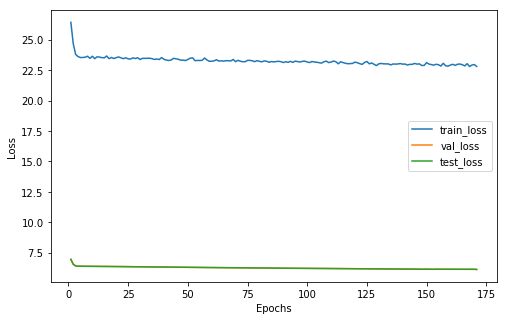

Cofusion Matrix For Test Set: 
-  ---  -
2   21  0
0  111  1
2   34  3
-  ---  -
xxxxxxxxxxxxxx epoch: 175 xxxxxxxxxxxxxx
{0, 1, 2}


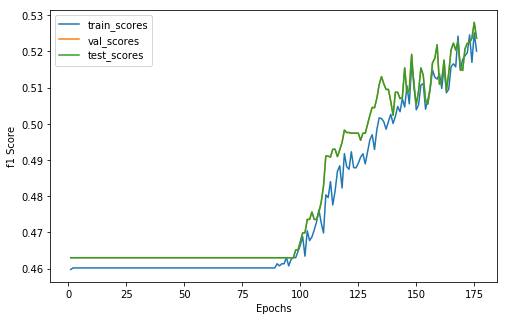

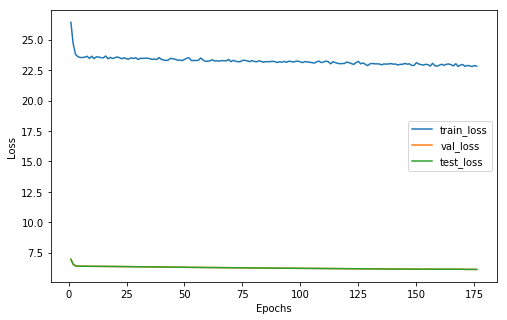

Cofusion Matrix For Test Set: 
-  ---  -
3   20  0
1  110  1
2   34  3
-  ---  -
xxxxxxxxxxxxxx epoch: 180 xxxxxxxxxxxxxx
{0, 1, 2}


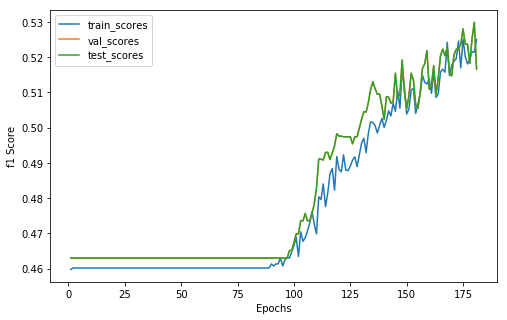

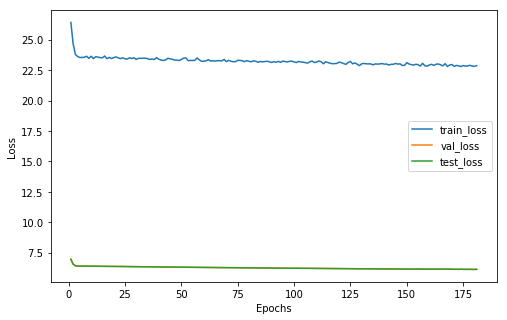

Cofusion Matrix For Test Set: 
-  ---  -
3   20  0
1  110  1
3   33  3
-  ---  -
xxxxxxxxxxxxxx epoch: 185 xxxxxxxxxxxxxx
{0, 1, 2}


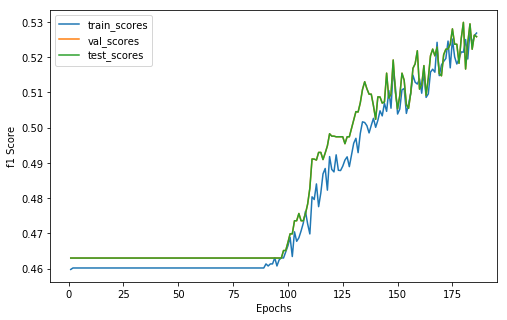

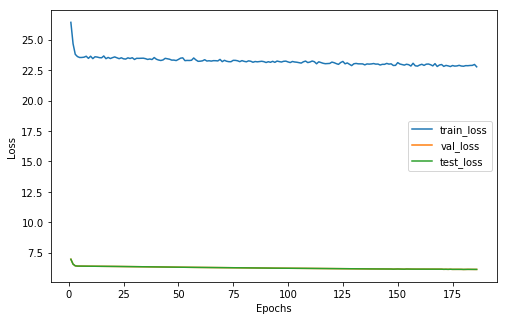

Cofusion Matrix For Test Set: 
-  ---  -
3   20  0
1  110  1
2   34  3
-  ---  -
xxxxxxxxxxxxxx epoch: 190 xxxxxxxxxxxxxx
{0, 1, 2}


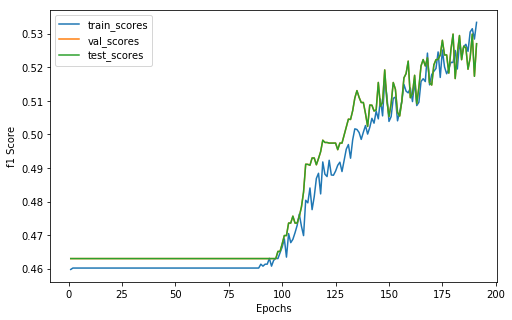

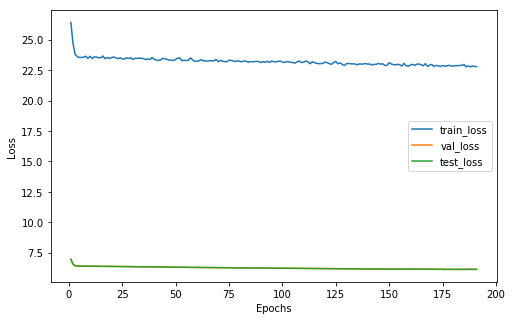

Cofusion Matrix For Test Set: 
-  ---  -
4   19  0
1  110  1
3   33  3
-  ---  -
xxxxxxxxxxxxxx epoch: 195 xxxxxxxxxxxxxx
{0, 1, 2}


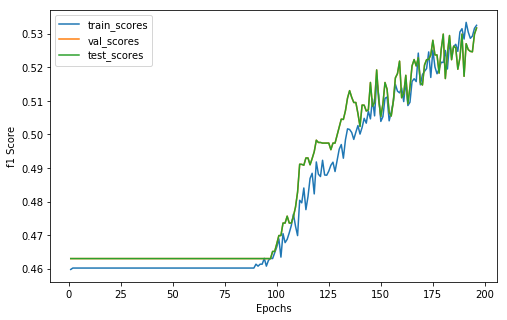

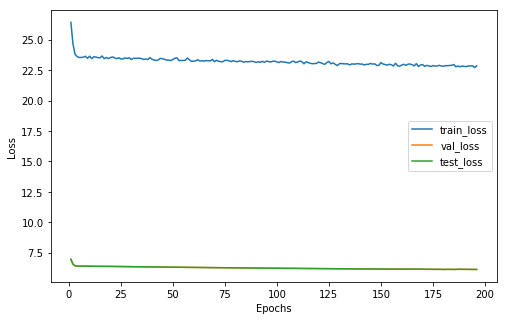

Cofusion Matrix For Test Set: 
-  ---  -
5   18  0
4  106  2
4   32  3
-  ---  -
X==XX==XX==XX==XX==X
best_test_f1: 0.531697013196916


In [44]:
running_loss = 0.0
best_test_f1 = 0
best_val_f1 = 0
loss_over_epochs, scores_over_epochs = plotting.get_empty_stat_over_n_epoch_dictionaries()
for epoch in range(n_epochs):
    fold_train_scores = []
    fold_test_scores  = []
    fold_train_loss   = []
    fold_test_loss    = []
    
    all_train_labels = []
    for fold, (train_loader, test_loader) in enumerate(loaders):
        train_loss, train_labels, train_preds = eval_network(train_loader, net, criterion, optimizer, training=True)
        test_loss, test_labels, test_preds = eval_network(test_loader, net, criterion, optimizer)
        all_train_labels += train_labels
#         print('labels',train_labels[:10])
#         print('preds',train_preds[:10])
#         print("\n")
        train_scores = metrics.precision_recall_fscore_support(train_labels, train_preds, average='weighted')
        test_scores = metrics.precision_recall_fscore_support(test_labels, test_preds, average='weighted')
        
        fold_train_scores.append(list(train_scores[:-1]))
        fold_test_scores.append(list(test_scores[:-1]))
        
        fold_train_loss.append(train_loss)
        fold_test_loss.append(test_loss)
        
    
    avg_train_scores = np.mean(np.array(fold_train_scores), axis=0)
    avg_test_scores  = np.mean(np.array(fold_test_scores), axis=0)
    
    avg_train_loss   = np.mean(np.array(fold_train_loss))
    avg_test_loss    = np.mean(np.array(fold_test_loss))
    
    scores_over_epochs['train_scores'].append(avg_train_scores)
    scores_over_epochs['val_scores'].append(avg_test_scores)
    scores_over_epochs['test_scores'].append(avg_test_scores)

    loss_over_epochs['train_loss'].append(avg_train_loss)
    loss_over_epochs['val_loss'].append(avg_test_loss)
    loss_over_epochs['test_loss'].append(avg_test_loss)
    
    best_test_f1 = max(best_test_f1, avg_test_scores[-1])

    if epoch%5 == 0:
        print("xxxxxxxxxxxxxx epoch: {} xxxxxxxxxxxxxx".format(epoch))
        print(set(all_train_labels))
        plotting.plot_score_over_n_epochs(scores_over_epochs, score_type='f1', fig_size=(8,5))
        plotting.plot_loss_over_n_epochs(loss_over_epochs, fig_size=(8, 5))
        print("Cofusion Matrix For Test Set: ")
        print(tabulate( metrics.confusion_matrix(test_labels, test_preds)))
#         print("Predicted Label Distribution:")
#         print(statistics.get_train_test_val_label_counts_from_predictions(train_preds, val_preds, test_preds))
    

print("X==X"*5)
print("best_test_f1: {}".format(best_test_f1))
# print("best_val_f1: {}".format(best_val_f1))
    

In [28]:
torch.LongTensor([12,3]).numpy().tolist()


[12, 3]

In [13]:
torch.Tensor([2222,1]).max()

tensor(2222.)

In [ ]:
def get_k_fod_cross_val_splits_stratified_by_students(data: dict, n_splits=5, stratification_type="student_label"):

    splits = []

    data_keys = data['data'].keys()
    keys, labels = conversions.extract_keys_and_labels_from_dict(data)
    student_ids = conversions.extract_student_ids_from_keys(keys)
    student_ids_label = []

    for i in range(len(student_ids)):
        student_ids_label.append(str(student_ids[i]) + "_" + str(labels[i]))

    student_ids_label = np.array(student_ids_label)
    data_keys = np.array(list(data_keys))
    student_ids = conversions.convert_list_of_strings_to_list_of_ints(student_ids)

    if stratification_type == "student":
        stratification_column = student_ids
    else:
        stratification_column = student_ids_label

    print(stratification_type)

    splitter = StratifiedKFold(n_splits=n_splits, random_state=SPLITTER_RANDOM_STATE)
    for train_index, val_index in splitter.split(X=data_keys, y=stratification_column):

        splitting_dict = {}
        splitting_dict['train_ids'] = data_keys[train_index].tolist()
        splitting_dict['val_ids'] = data_keys[val_index].tolist()
        splits.append(splitting_dict)

    return splits

In [32]:

print("{:.3f}".format(float(0.232451)))


0.232


In [ ]:
torch.randn((3,2))

In [ ]:
torch.nn.Linear